## 1. Imports & Setup

Initializes libraries, model classes, and tools. Sets plotting style and ensures the model directory exists.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import glob
import re

# Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Sklearn Tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Setup plotting
sns.set_style("whitegrid")

# Create models folder if it doesn't exist
if not os.path.exists("../../models"):
    os.makedirs("../../models")

## 2. Load & Preprocess Data

Loads the cleaned dataset

In [11]:
# FIND FILE AUTOMATICALLY
files = glob.glob("../../Datasets/Cleaned_Datasets/Marketing/*.csv")

if not files:
    raise FileNotFoundError("No CSV files found. Check your path!")

files.sort()

print(f"Loading file: {files[0]}")
df = pd.read_csv(files[0])
print(f"Final Data Shape: {df.shape}")

Loading file: ../../Datasets/Cleaned_Datasets/Marketing\marketing_cleaned_prepared.csv
Final Data Shape: (72206, 20)


## 3. Feature Engineering & Selection

Defines the target variable, removes potential data leakage, splits the data, and selects the top 10 most relevant features.

✅ Input Features: 14
🗑️ Dropped Leakage: ['overcost', 'campaign_item_id', 'media_cost_usd', 'clicks', 'impressions', 'Unnamed: 0']

🔍 Training Inspector Models to compare Feature Importance...
   -> Analyzing with RandomForest...
   -> Analyzing with XGBoost...
   -> Analyzing with LightGBM...


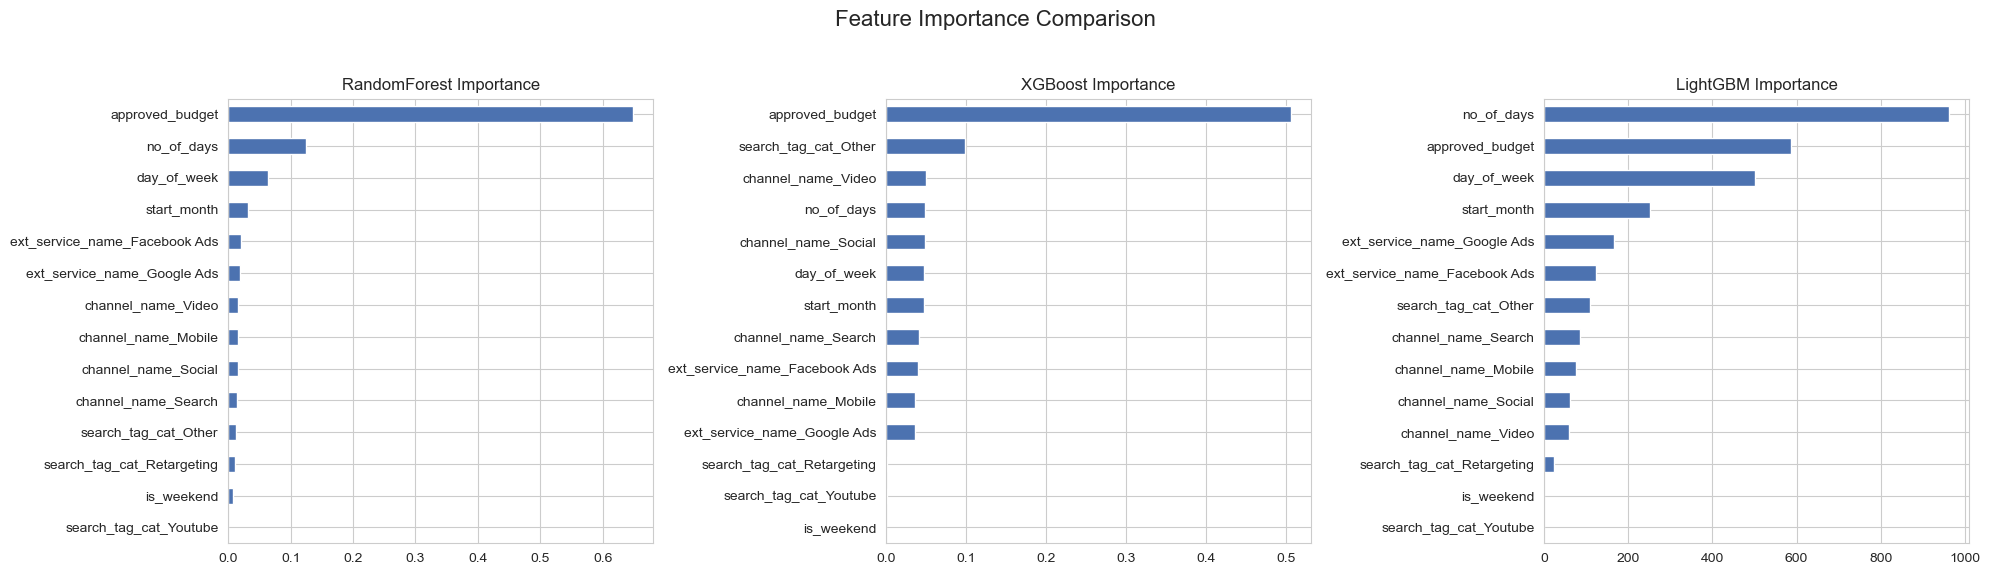

In [12]:
# DEFINE TARGET & LEAKAGE
TARGET = 'overcost'

leakage_cols = [
    TARGET,
    'campaign_item_id',
    'campaign_budget_usd',
    'media_cost_usd',
    'clicks', 'impressions',
    'Unnamed: 0', 'Unnamed__0'
]

# safely find which columns to drop
cols_to_drop = [c for c in leakage_cols if c in df.columns]
X = df.drop(columns=cols_to_drop)
y = df[TARGET]

print(f"✅ Input Features: {X.shape[1]}")
print(f"🗑️ Dropped Leakage: {cols_to_drop}")

# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n🔍 Training Inspector Models to compare Feature Importance...")

inspectors = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Feature Importance Comparison', fontsize=16)

for i, (name, model) in enumerate(inspectors.items()):
    print(f"   -> Analyzing with {name}...")
    model.fit(X_train, y_train)
    
    importances = model.feature_importances_
    feat_series = pd.Series(importances, index=X_train.columns)
    
    ax = axes[i]
    feat_series.nlargest(15).plot(kind='barh', ax=ax, color='#4c72b0')
    ax.set_title(f"{name} Importance")
    ax.invert_yaxis()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Baseline Model Evaluation

Trains standard models (RandomForest, XGBoost, LightGBM) without optimization to establish a performance baseline. Calculates key metrics R2, RMSE, and Cross-Validation scores to assess initial accuracy.

In [13]:
from sklearn.pipeline import Pipeline

# Define Baseline Models
models = {
    'RandomForest': RandomForestRegressor(random_state=42), 
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror'),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1)
}

print("\n📊 MARKET ENGINE BASELINE RESULTS")
print("-" * 115)
print(f"{'Model':<15} | {'Test R2':<10} | {'Train R2':<10} | {'Gap':<10} | {'RMSE':<12} | {'CV Score':<10}")
print("-" * 115)

for name, model in models.items():
    # Create Pipeline
    pipeline = Pipeline([
        ('selector', SelectKBest(score_func=f_regression, k=10).set_output(transform="pandas")),
        ('regressor', model)
    ])
    
    # Train Pipeline on Full Train Set
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred_test = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)
    
    # Standard Metrics
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    gap = r2_train - r2_test
    
    # Calculate Cross-Validation Score
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    cv_avg = cv_scores.mean()
    
    print(f"{name:<15} | {r2_test:.4f}     | {r2_train:.4f}     | {gap:.4f}     | ${rmse:,.0f}    | {cv_avg:.4f}")

print("-" * 115)


📊 MARKET ENGINE BASELINE RESULTS
-------------------------------------------------------------------------------------------------------------------
Model           | Test R2    | Train R2   | Gap        | RMSE         | CV Score  
-------------------------------------------------------------------------------------------------------------------
RandomForest    | 0.5108     | 0.8743     | 0.3634     | $84,325    | 0.5099
XGBoost         | 0.4170     | 0.8621     | 0.4450     | $92,056    | 0.4353
LightGBM        | 0.5717     | 0.7333     | 0.1616     | $78,909    | 0.5701
-------------------------------------------------------------------------------------------------------------------


## 5. Hyperparameter Optimization

Performs Randomized Search Cross-Validation to fine-tune hyperparameters for each model. Evaluates the optimized models on Test data and automatically selects the best performer based on the Test R2 Score.

In [14]:
# ------------------------------------------------------------------------------
# 🧪 EXPERIMENT 2: METHOD OF SELECTION (Linear vs. Non-Linear)
# ------------------------------------------------------------------------------
# "Mutual Information" might find complex patterns that "F-Regression" missed.
# ------------------------------------------------------------------------------

import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.feature_selection import mutual_info_regression, f_regression

# WARNING SILENCER
warnings.filterwarnings('ignore') 

# Define the Methods to Test
selection_methods = {
    'F-Regression (Linear)': f_regression,
    'Mutual Info (Complex)': mutual_info_regression
}

# Define Parameter Grids
param_grids = {
    'RandomForest': {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [10, 20, None]
    },
    'XGBoost': {
        'regressor__n_estimators': [100, 300],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__max_depth': [3, 5]
    },
    'LightGBM': {
        'regressor__n_estimators': [100, 300],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__num_leaves': [31, 50]
    }
}

print(f"\n🧪 STARTING METHOD EXPERIMENTS (Testing {len(selection_methods)} Methods)")
print("=" * 125)
print(f"{'Method':<25} | {'Model':<15} | {'Test R2':<10} | {'Train R2':<10} | {'RMSE':<12} | {'CV Score':<10}")
print("=" * 125)

global_best_r2 = -float('inf')
best_opt_model = None
best_model_name = None 
best_opt_rmse = 0

# LOOP 1: Iterate through Selection Methods
for method_name, method_func in selection_methods.items():
    
    # LOOP 2: Iterate through Models
    for name, model in models.items():
        if name in param_grids:
            
            # Setup Pipeline
            pipeline = Pipeline([
                ('selector', SelectKBest(score_func=method_func, k=10).set_output(transform="pandas")), 
                ('regressor', model)
            ])

            # Setup Search
            search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_grids[name],
                n_iter=5, 
                cv=3, 
                scoring='r2', 
                n_jobs=-1, 
                random_state=42
            )
            
            # Fit
            search.fit(X_train, y_train)
            
            # Metrics
            opt_pipeline = search.best_estimator_
            cv_score = search.best_score_
            
            y_pred_test = opt_pipeline.predict(X_test)
            y_pred_train = opt_pipeline.predict(X_train)
            
            r2_test = r2_score(y_test, y_pred_test)
            r2_train = r2_score(y_train, y_pred_train)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            
            print(f"{method_name:<25} | {name:<15} | {r2_test:.4f}     | {r2_train:.4f}     | {rmse:.5f}      | {cv_score:.4f}")
            
            if r2_test > global_best_r2:
                global_best_r2 = r2_test
                best_opt_rmse = rmse
                best_opt_model = opt_pipeline
                short_method = "MutInfo" if "Mutual" in method_name else "FReg"
                best_model_name = f"{name}_{short_method}"

print("=" * 125)
print(f"🏆 METHOD CHAMPION: {best_model_name} with R2: {global_best_r2:.4f}")

best_opt_r2 = global_best_r2


🧪 STARTING METHOD EXPERIMENTS (Testing 2 Methods)
Method                    | Model           | Test R2    | Train R2   | RMSE         | CV Score  
F-Regression (Linear)     | RandomForest    | 0.5659     | 0.7987     | 79436.35279      | 0.5714
F-Regression (Linear)     | XGBoost         | 0.6178     | 0.6559     | 74538.84105      | 0.6231
F-Regression (Linear)     | LightGBM        | 0.6122     | 0.6852     | 75081.36336      | 0.5987
Mutual Info (Complex)     | RandomForest    | 0.5829     | 0.7946     | 77864.93957      | 0.5676
Mutual Info (Complex)     | XGBoost         | 0.6297     | 0.6522     | 73371.43867      | 0.6196
Mutual Info (Complex)     | LightGBM        | 0.6345     | 0.6824     | 72889.66079      | 0.5945
🏆 METHOD CHAMPION: LightGBM_MutInfo with R2: 0.6345


## 6. Feature Importance Visualization

Extracts and visualizes the top 5 most influential features for each model. This step show exactly which data points the models are prioritizing for their predictions.


Training LightGBM_MutInfo for Visualization...
✅ LightGBM_MutInfo Top Features:
                      Feature  Importance
                   no_of_days        3968
              approved_budget        2287
                  start_month         912
ext_service_name_Facebook Ads         522
                   is_weekend         469
          channel_name_Mobile         356
         search_tag_cat_Other         292
           channel_name_Video         194
   search_tag_cat_Retargeting           0
       search_tag_cat_Youtube           0


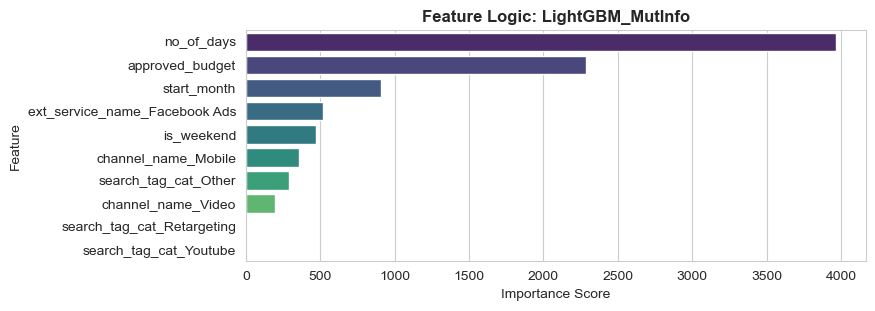

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


In [15]:
# Visualize the Best Model's Features
if best_opt_model is not None:
    print(f"\nTraining {best_model_name} for Visualization...")
    
    # Extract parts from pipeline
    selector = best_opt_model.named_steps['selector']
    regressor = best_opt_model.named_steps['regressor']
    
    # Get Feature Names
    selected_mask = selector.get_support()
    selected_names = X_train.columns[selected_mask]
    
    # Extract Feature Importance
    if hasattr(regressor, 'feature_importances_'):
        importances = regressor.feature_importances_
        
        # Create a clean DataFrame
        feat_df = pd.DataFrame({
            'Feature': selected_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(10)
        
        print(f"✅ {best_model_name} Top Features:")
        print(feat_df.to_string(index=False))
        
        # Plot
        plt.figure(figsize=(8, 3))
        sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
        plt.title(f'Feature Logic: {best_model_name}', fontsize=12, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.show()
        print("▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬")
    else:
        print(f"⚠️ Model {best_model_name} does not support feature importance.")

## 7. Prediction Evaluation

Selects the best performing model and validates its value by comparing it against a "Naive Baseline" (simply guessing the average conversion rate for everyone).

In [16]:
# Select the Best Model
if best_opt_model is not None:
    final_model = best_opt_model
    model_name = best_model_name
    print(f"✅ Evaluating Optimized Model: {model_name}")
else:
    # Fallback
    model_name = list(models.keys())[0]
    final_model = Pipeline([
        ('selector', SelectKBest(score_func=f_regression, k=10)),
        ('regressor', models[model_name])
    ])
    final_model.fit(X_train, y_train)
    print(f"⚠️ Evaluating: First Model ({model_name}) - Winner not found")

# Get Predictions
y_pred = final_model.predict(X_test)

baseline_preds = np.zeros(len(y_test)) 

baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
model_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
improvement = baseline_rmse - model_rmse

print(f"\n📊 Baseline Comparison:")
print(f"   1. Baseline RMSE (Assuming Cost = Budget): ${baseline_rmse:,.0f}")
print(f"   2. AI Model RMSE (Your Prediction):        ${model_rmse:,.0f}")
print(f"   ------------------------------------------------------")

if improvement > 0:
    print(f"   ✅ SUCCESS: AI beats the baseline by ${improvement:,.0f}!")
else:
    print(f"   ❌ FAIL: The AI is worse than just guessing 0.")

✅ Evaluating Optimized Model: LightGBM_MutInfo

📊 Baseline Comparison:
   1. Baseline RMSE (Assuming Cost = Budget): $122,469
   2. AI Model RMSE (Your Prediction):        $72,890
   ------------------------------------------------------
   ✅ SUCCESS: AI beats the baseline by $49,579!


## 8. Save Model

Persists the final, best performing model to a .joblib file. The filename is automatically versioned with the model type, its R2 accuracy score, and a timestamp to ensure reproducibility and easy tracking of experiments.

In [17]:
#show all columns in order
pd.set_option('display.max_columns', None)
print(X.head())

   no_of_days  approved_budget  start_month  day_of_week  is_weekend  \
0           7            400.0            5            6           1   
1           8            400.0            5            0           0   
2           9            400.0            5            1           0   
3          10            400.0            5            2           0   
4          11            400.0            5            3           0   

   ext_service_name_Facebook Ads  ext_service_name_Google Ads  \
0                              1                            0   
1                              0                            0   
2                              1                            0   
3                              1                            0   
4                              0                            1   

   channel_name_Mobile  channel_name_Search  channel_name_Social  \
0                    1                    0                    0   
1                    0                  

In [18]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

if final_model is not None:
    r2_to_save = best_opt_r2 if best_opt_r2 > -float('inf') else 0.0
    
    filename = f"Marketing_Model_{model_name}_Opt_R2-{r2_to_save:.3f}_{timestamp}.joblib"
    save_dir = "../Model_Training/Trained_Models/Marketing"
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    save_path = os.path.join(save_dir, filename)
    joblib.dump(final_model, save_path)
    print(f"✅ Saved Marketing Model: {save_path}")
else:
    print("❌ No model to save.")

✅ Saved Marketing Model: ../Model_Training/Trained_Models/Marketing\Marketing_Model_LightGBM_MutInfo_Opt_R2-0.635_20260118_0251.joblib
